In [1]:
import pandas as pd
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, BatchNormalization,Input,LeakyReLU
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import keras.backend as Kr
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from numpy import exp
import matplotlib.pyplot as plt
import matplotlib;matplotlib.rcParams['figure.figsize'] = (0.5,0.4)
import pylab 
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm.keras import TqdmCallback

num_sim = 100


def model_function(df_train, phi, dummy_y, num_class, sim_iteration):
    print("##### Warning messages ######")

    
    class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(df_train["threshold"]),
                                     y=df_train["threshold"])
    
    class_weight_dict = dict(enumerate(class_weights))
    # DeepKriging model for continuous data
    model = Sequential()

    model.add(Dense(100, input_dim = phi.shape[1],kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))

    model.add(Dense(num_class, activation='softmax'))
    optimizer = keras.optimizers.Adam(learning_rate=0.0012)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_accuracy', patience=200),
                 ModelCheckpoint(filepath='indicator_kriging.h5', 
                                 monitor='val_accuracy', save_best_only=True),
                                 TqdmCallback(verbose=1)] 
    print("##### End of warning messages ######")
    print('<<<<<<<<<<<<<<<< Fitting DNN-model for %4d-th simulation >>>>>>>>>>>>>>>>>'%(sim_iteration + 1))
    result = model.fit(phi, dummy_y, callbacks=callbacks, class_weight = class_weight_dict,
               validation_split = 0.1, epochs = 500, batch_size = 64, verbose = 0)
    model = keras.models.load_model('indicator_kriging.h5')
    plt.plot(result.history['loss'], label='Train Loss')
    plt.plot(result.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


    return model


In [2]:
import time
import pandas as pd

def Tgh_Deepkriging(g_val, h_val):
    time_records = []

    for sim in range(num_sim):
        start_total = time.time()

        # ========== Load and split data ==========
        file_path = f"synthetic_data_simulations/Tgh_nonGaussian_3600_classification_g{g_val}_h{h_val}_{sim+1}.csv"
        df_loc = pd.read_csv(file_path)
        df_train, df_test = train_test_split(df_loc, test_size=0.1, random_state=123)
        df_train.reset_index(drop=True, inplace=True)
        df_test.reset_index(drop=True, inplace=True)
        
        train_file = "synthetic_data_simulations/training_data/Tgh_nonGaussian_3600_classification_g{}_h{}_{}train.csv".format(g_val, h_val, sim+1)
        test_file  = "synthetic_data_simulations/testing_data/Tgh_nonGaussian_3600_classification_g{}_h{}_{}test.csv".format(g_val, h_val, sim+1)
        df_train.to_csv(train_file, index=False)
        df_test.to_csv(test_file, index=False)

        # ========== Prepare training data ==========
        df_train1 = df_train.copy()
        df_train1["threshold"] = df_train1["threshold"] - 1
        dummy_y = np_utils.to_categorical(df_train1["threshold"])
        n = dummy_y.shape[1]
        print('Total number of classes %4d' %(n))
        N = len(df_train1)
        print('Training data size %4d' %(N))
        s = np.vstack((df_train1["x"],df_train1["y"])).T

        # ========== Basis construction ==========
        num_basis = [5**2, 7**2, 11**2]
        knots_1d = [np.linspace(0, 1, int(np.sqrt(i))) for i in num_basis]
        K = 0
        phi = np.zeros((N, sum(num_basis)))

        for res in range(len(num_basis)):
            theta = 1 / np.sqrt(num_basis[res]) * 2.5
            knots_s1, knots_s2 = np.meshgrid(knots_1d[res], knots_1d[res])
            knots = np.column_stack((knots_s1.flatten(), knots_s2.flatten()))
            for i in range(num_basis[res]):
                d = np.linalg.norm(s - knots[i, :], axis=1) / theta
                phi[:, i + K] = np.where(
                    (d >= 0) & (d <= 1),
                    (1 - d) ** 6 * (35 * d**2 + 18 * d + 3) / 3,
                    0
                )
            K += num_basis[res]

        # ========== Train the model ==========
        train_start = time.time()
        model = model_function(df_train, phi, dummy_y, n, sim)
        train_end = time.time()

        # ========== Construct test basis ==========
        s_test = np.vstack((df_test["x"], df_test["y"])).T
        N_test = len(df_test)
        phi_test = np.zeros((N_test, sum(num_basis)))

        K = 0
        for res in range(len(num_basis)):
            theta = 1 / np.sqrt(num_basis[res]) * 2.5
            knots_s1, knots_s2 = np.meshgrid(knots_1d[res], knots_1d[res])
            knots = np.column_stack((knots_s1.flatten(), knots_s2.flatten()))
            for i in range(num_basis[res]):
                d = np.linalg.norm(s_test - knots[i, :], axis=1) / theta
                phi_test[:, i + K] = np.where(
                    (d >= 0) & (d <= 1),
                    (1 - d) ** 6 * (35 * d**2 + 18 * d + 3) / 3,
                    0
                )
            K += num_basis[res]

        # ========== Prediction ==========
        val_start = time.time()
        pred = model.predict(phi_test)
        val_end = time.time()

        # ========== Save prediction ==========
        pred_df = pd.DataFrame(pred)
        df_test_preds = pd.concat([df_test, pred_df], axis=1)
        out_file = f"Results_DNN/Tgh_nonGaussian_3600_classification_g{g_val}_h{h_val}_{sim+1}.csv"
        df_test_preds.to_csv(out_file, index=False)

        # ========== Record computation time ==========
        time_records.append({
            "simulation": sim + 1,
            "train_time_sec": train_end - train_start,
            "val_time_sec": val_end - val_start
        })

    # ========== Save and report average times ==========
    df_times = pd.DataFrame(time_records)
    df_times.to_csv(f"DNN_time_records_g{g_val}_h{h_val}.csv", index=False)

    print("Average training time (sec):", df_times['train_time_sec'].mean())
    print("Average validation time (sec):", df_times['val_time_sec'].mean())


Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for    1-th simulation >>>>>>>>>>>>>>>>>


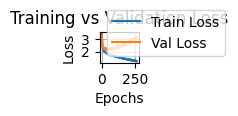

12/12 [==============================] - 0s 3ms/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for    2-th simulation >>>>>>>>>>>>>>>>>


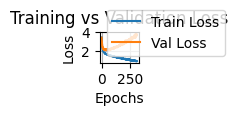

12/12 [==============================] - 0s 504us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for    3-th simulation >>>>>>>>>>>>>>>>>


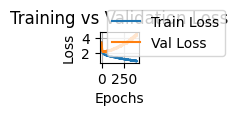

12/12 [==============================] - 0s 613us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for    4-th simulation >>>>>>>>>>>>>>>>>


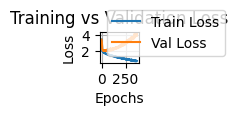

12/12 [==============================] - 0s 667us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for    5-th simulation >>>>>>>>>>>>>>>>>


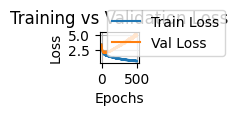

12/12 [==============================] - 0s 534us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for    6-th simulation >>>>>>>>>>>>>>>>>


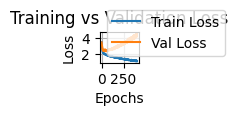

12/12 [==============================] - 0s 476us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for    7-th simulation >>>>>>>>>>>>>>>>>


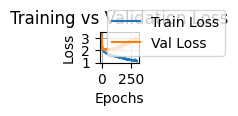

12/12 [==============================] - 0s 535us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for    8-th simulation >>>>>>>>>>>>>>>>>


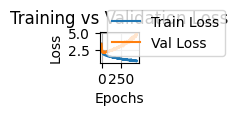

12/12 [==============================] - 0s 537us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for    9-th simulation >>>>>>>>>>>>>>>>>


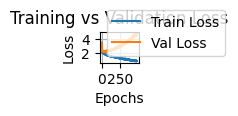

12/12 [==============================] - 0s 482us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   10-th simulation >>>>>>>>>>>>>>>>>


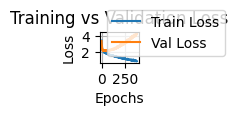

12/12 [==============================] - 0s 455us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   11-th simulation >>>>>>>>>>>>>>>>>


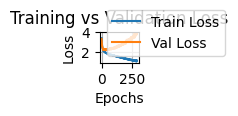

12/12 [==============================] - 0s 499us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   12-th simulation >>>>>>>>>>>>>>>>>


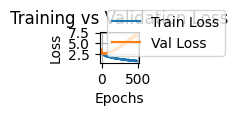

12/12 [==============================] - 0s 514us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   13-th simulation >>>>>>>>>>>>>>>>>


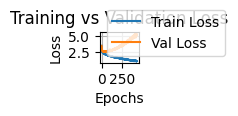

12/12 [==============================] - 0s 548us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   14-th simulation >>>>>>>>>>>>>>>>>


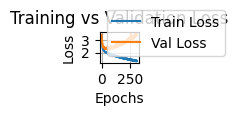

12/12 [==============================] - 0s 484us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   15-th simulation >>>>>>>>>>>>>>>>>


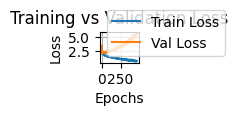

12/12 [==============================] - 0s 529us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   16-th simulation >>>>>>>>>>>>>>>>>


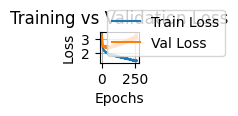

12/12 [==============================] - 0s 468us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   17-th simulation >>>>>>>>>>>>>>>>>


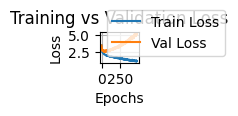

12/12 [==============================] - 0s 478us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   18-th simulation >>>>>>>>>>>>>>>>>


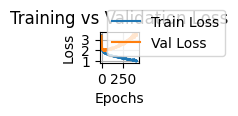

12/12 [==============================] - 0s 545us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   19-th simulation >>>>>>>>>>>>>>>>>


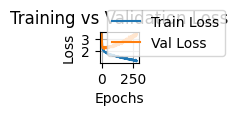

12/12 [==============================] - 0s 459us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   20-th simulation >>>>>>>>>>>>>>>>>


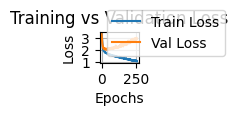

12/12 [==============================] - 0s 487us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   21-th simulation >>>>>>>>>>>>>>>>>


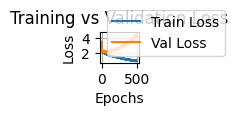

12/12 [==============================] - 0s 562us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   22-th simulation >>>>>>>>>>>>>>>>>


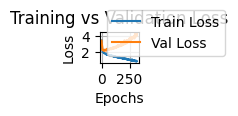

12/12 [==============================] - 0s 536us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   23-th simulation >>>>>>>>>>>>>>>>>


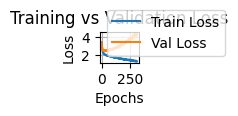

12/12 [==============================] - 0s 560us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   24-th simulation >>>>>>>>>>>>>>>>>


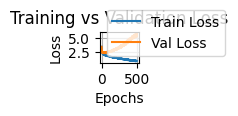

12/12 [==============================] - 0s 453us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   25-th simulation >>>>>>>>>>>>>>>>>


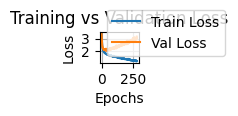

12/12 [==============================] - 0s 484us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   26-th simulation >>>>>>>>>>>>>>>>>


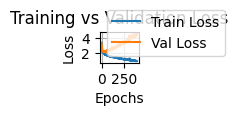

12/12 [==============================] - 0s 558us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   27-th simulation >>>>>>>>>>>>>>>>>


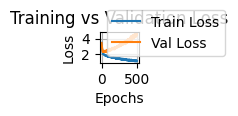

12/12 [==============================] - 0s 522us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   28-th simulation >>>>>>>>>>>>>>>>>


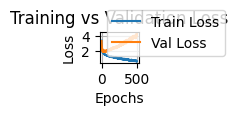

12/12 [==============================] - 0s 490us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   29-th simulation >>>>>>>>>>>>>>>>>


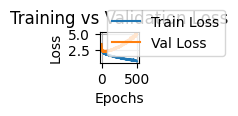

12/12 [==============================] - 0s 467us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   30-th simulation >>>>>>>>>>>>>>>>>


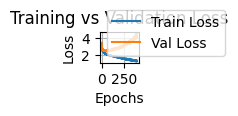

12/12 [==============================] - 0s 487us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   31-th simulation >>>>>>>>>>>>>>>>>


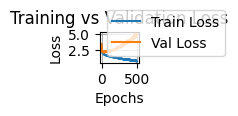

12/12 [==============================] - 0s 535us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   32-th simulation >>>>>>>>>>>>>>>>>


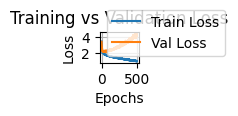

12/12 [==============================] - 0s 508us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   33-th simulation >>>>>>>>>>>>>>>>>


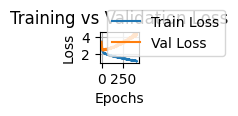

12/12 [==============================] - 0s 484us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   34-th simulation >>>>>>>>>>>>>>>>>


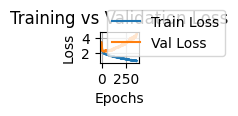

12/12 [==============================] - 0s 541us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   35-th simulation >>>>>>>>>>>>>>>>>


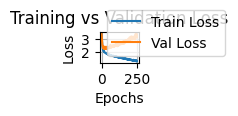

12/12 [==============================] - 0s 499us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   36-th simulation >>>>>>>>>>>>>>>>>


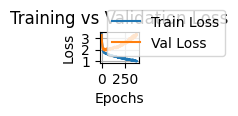

12/12 [==============================] - 0s 462us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   37-th simulation >>>>>>>>>>>>>>>>>


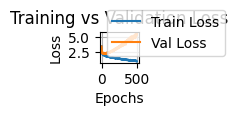

12/12 [==============================] - 0s 509us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   38-th simulation >>>>>>>>>>>>>>>>>


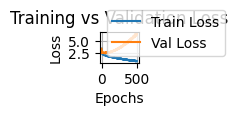

12/12 [==============================] - 0s 578us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   39-th simulation >>>>>>>>>>>>>>>>>


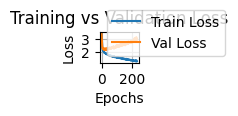

12/12 [==============================] - 0s 552us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   40-th simulation >>>>>>>>>>>>>>>>>


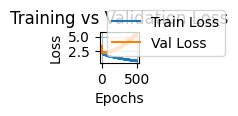

12/12 [==============================] - 0s 486us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   41-th simulation >>>>>>>>>>>>>>>>>


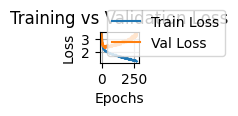

12/12 [==============================] - 0s 559us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   42-th simulation >>>>>>>>>>>>>>>>>


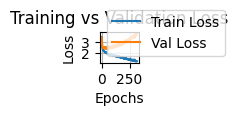

12/12 [==============================] - 0s 479us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   43-th simulation >>>>>>>>>>>>>>>>>


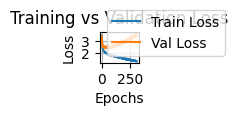

12/12 [==============================] - 0s 507us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   44-th simulation >>>>>>>>>>>>>>>>>


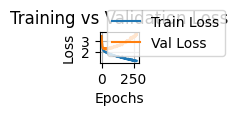

12/12 [==============================] - 0s 488us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   45-th simulation >>>>>>>>>>>>>>>>>


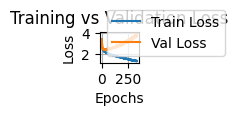

12/12 [==============================] - 0s 473us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   46-th simulation >>>>>>>>>>>>>>>>>


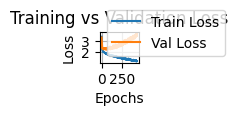

12/12 [==============================] - 0s 551us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   47-th simulation >>>>>>>>>>>>>>>>>


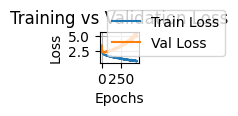

12/12 [==============================] - 0s 513us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   48-th simulation >>>>>>>>>>>>>>>>>


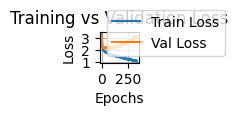

12/12 [==============================] - 0s 738us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   49-th simulation >>>>>>>>>>>>>>>>>


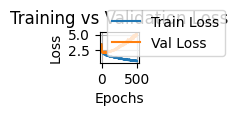

12/12 [==============================] - 0s 497us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   50-th simulation >>>>>>>>>>>>>>>>>


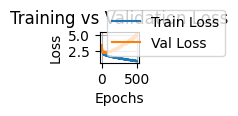

12/12 [==============================] - 0s 553us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   51-th simulation >>>>>>>>>>>>>>>>>


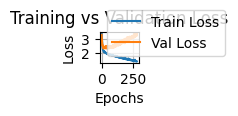

12/12 [==============================] - 0s 494us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   52-th simulation >>>>>>>>>>>>>>>>>


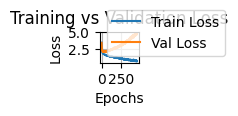

12/12 [==============================] - 0s 545us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   53-th simulation >>>>>>>>>>>>>>>>>


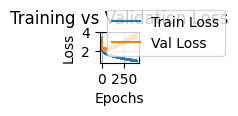

12/12 [==============================] - 0s 517us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   54-th simulation >>>>>>>>>>>>>>>>>


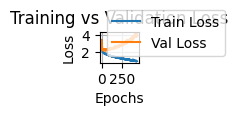

12/12 [==============================] - 0s 465us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   55-th simulation >>>>>>>>>>>>>>>>>


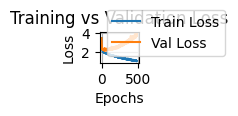

12/12 [==============================] - 0s 528us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   56-th simulation >>>>>>>>>>>>>>>>>


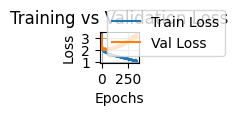

12/12 [==============================] - 0s 517us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   57-th simulation >>>>>>>>>>>>>>>>>


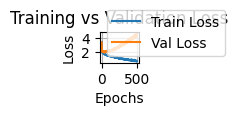

12/12 [==============================] - 0s 616us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   58-th simulation >>>>>>>>>>>>>>>>>


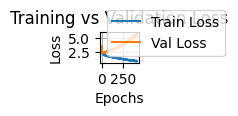

12/12 [==============================] - 0s 462us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   59-th simulation >>>>>>>>>>>>>>>>>


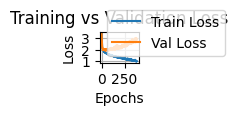

12/12 [==============================] - 0s 508us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   60-th simulation >>>>>>>>>>>>>>>>>


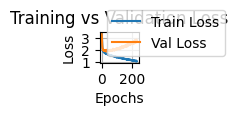

12/12 [==============================] - 0s 557us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   61-th simulation >>>>>>>>>>>>>>>>>


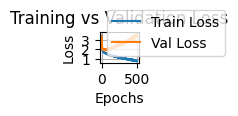

12/12 [==============================] - 0s 469us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   62-th simulation >>>>>>>>>>>>>>>>>


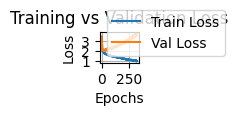

12/12 [==============================] - 0s 485us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   63-th simulation >>>>>>>>>>>>>>>>>


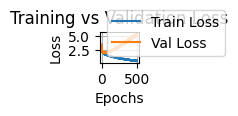

12/12 [==============================] - 0s 481us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   64-th simulation >>>>>>>>>>>>>>>>>


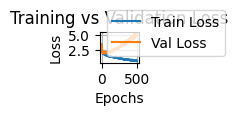

12/12 [==============================] - 0s 511us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   65-th simulation >>>>>>>>>>>>>>>>>


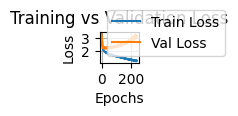

12/12 [==============================] - 0s 441us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   66-th simulation >>>>>>>>>>>>>>>>>


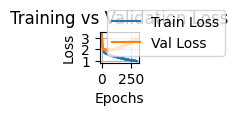

12/12 [==============================] - 0s 455us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   67-th simulation >>>>>>>>>>>>>>>>>


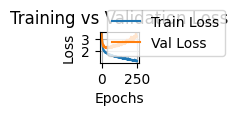

12/12 [==============================] - 0s 450us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   68-th simulation >>>>>>>>>>>>>>>>>


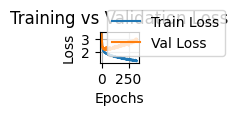

12/12 [==============================] - 0s 533us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   69-th simulation >>>>>>>>>>>>>>>>>


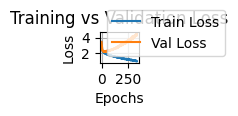

12/12 [==============================] - 0s 522us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   70-th simulation >>>>>>>>>>>>>>>>>


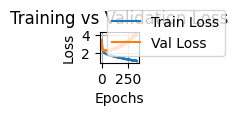

12/12 [==============================] - 0s 505us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   71-th simulation >>>>>>>>>>>>>>>>>


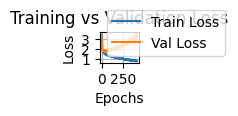

12/12 [==============================] - 0s 500us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   72-th simulation >>>>>>>>>>>>>>>>>


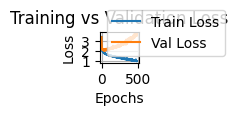

12/12 [==============================] - 0s 467us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   73-th simulation >>>>>>>>>>>>>>>>>


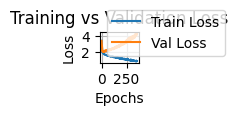

12/12 [==============================] - 0s 561us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   74-th simulation >>>>>>>>>>>>>>>>>


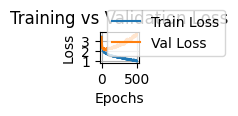

12/12 [==============================] - 0s 524us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   75-th simulation >>>>>>>>>>>>>>>>>


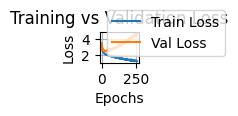

12/12 [==============================] - 0s 467us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   76-th simulation >>>>>>>>>>>>>>>>>


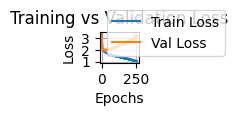

12/12 [==============================] - 0s 475us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   77-th simulation >>>>>>>>>>>>>>>>>


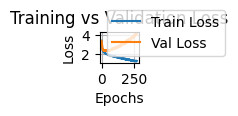

12/12 [==============================] - 0s 476us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   78-th simulation >>>>>>>>>>>>>>>>>


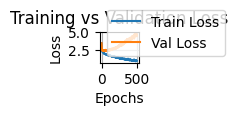

12/12 [==============================] - 0s 504us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   79-th simulation >>>>>>>>>>>>>>>>>


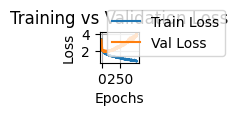

12/12 [==============================] - 0s 528us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   80-th simulation >>>>>>>>>>>>>>>>>


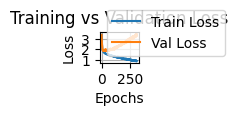

12/12 [==============================] - 0s 524us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   81-th simulation >>>>>>>>>>>>>>>>>


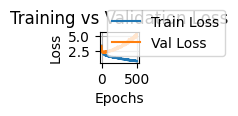

12/12 [==============================] - 0s 482us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   82-th simulation >>>>>>>>>>>>>>>>>


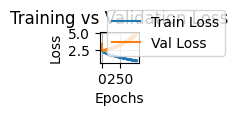

12/12 [==============================] - 0s 498us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   83-th simulation >>>>>>>>>>>>>>>>>


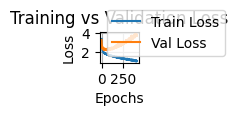

12/12 [==============================] - 0s 520us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   84-th simulation >>>>>>>>>>>>>>>>>


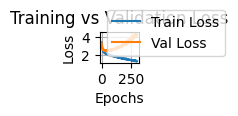

12/12 [==============================] - 0s 499us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   85-th simulation >>>>>>>>>>>>>>>>>


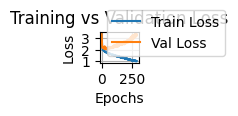

12/12 [==============================] - 0s 479us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   86-th simulation >>>>>>>>>>>>>>>>>


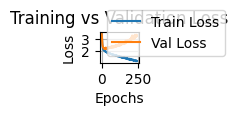

12/12 [==============================] - 0s 548us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   87-th simulation >>>>>>>>>>>>>>>>>


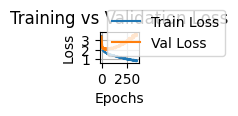

12/12 [==============================] - 0s 537us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   88-th simulation >>>>>>>>>>>>>>>>>


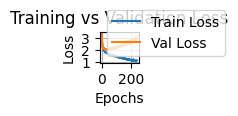

12/12 [==============================] - 0s 459us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   89-th simulation >>>>>>>>>>>>>>>>>


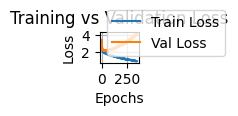

12/12 [==============================] - 0s 468us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   90-th simulation >>>>>>>>>>>>>>>>>


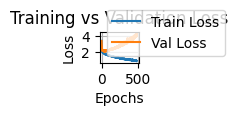

12/12 [==============================] - 0s 431us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   91-th simulation >>>>>>>>>>>>>>>>>


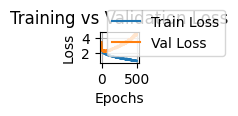

12/12 [==============================] - 0s 480us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   92-th simulation >>>>>>>>>>>>>>>>>


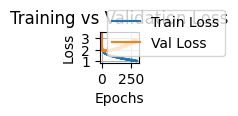

12/12 [==============================] - 0s 497us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   93-th simulation >>>>>>>>>>>>>>>>>


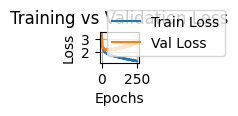

12/12 [==============================] - 0s 498us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   94-th simulation >>>>>>>>>>>>>>>>>


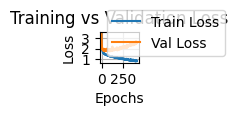

12/12 [==============================] - 0s 569us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   95-th simulation >>>>>>>>>>>>>>>>>


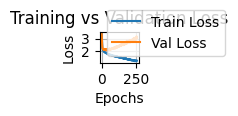

12/12 [==============================] - 0s 500us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   96-th simulation >>>>>>>>>>>>>>>>>


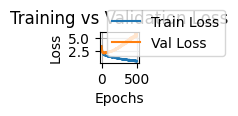

12/12 [==============================] - 0s 537us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   97-th simulation >>>>>>>>>>>>>>>>>


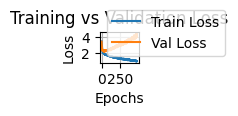

12/12 [==============================] - 0s 547us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   98-th simulation >>>>>>>>>>>>>>>>>


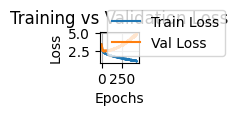

12/12 [==============================] - 0s 576us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for   99-th simulation >>>>>>>>>>>>>>>>>


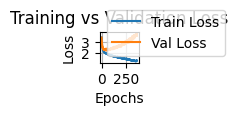

12/12 [==============================] - 0s 475us/step
Total number of classes   31
Training data size 3240
##### Warning messages ######


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### End of warning messages ######
<<<<<<<<<<<<<<<< Fitting DNN-model for  100-th simulation >>>>>>>>>>>>>>>>>


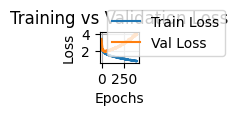

12/12 [==============================] - 0s 491us/step
Average training time (sec): 23.943113753795625
Average validation time (sec): 0.04971621036529541


In [3]:
Tgh_Deepkriging(0,0)